# Imports

In [1]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [2]:
np.random.seed(31071967)

In [3]:
# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# sanity check
project_config["TKL"]

'TNYA'

# Download TKL data from YF

In [5]:
from datetime import date, timedelta
end_date = date.today() - timedelta(days=1)
start_date = end_date - timedelta(days=int(project_config["HISTORY_DEPTH"]))

In [6]:
tickers_yf = {
    "y_today"     : f"{project_config['TKL']}",
    "NASDAQ"      : "^IXIC",
    "SP500"       : "^GSPC",
    "RealEstate"  : "VNQ",
    "Oil_WTI"     : "CL=F",
    "Gold": "GC=F"
}

tickers_fred = {
   # "Inflation_CPI" : "CPIAUCSL",
   # "Unemployment"  : "UNRATE"
}

In [7]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

# ---- DOWNLOAD FROM YAHOO FINANCE ----
ts_yf = yf.download(
    tickers=list(tickers_yf.values()),
    start=start_date,
    end=end_date,
    auto_adjust=True
)["Close"]

# rename columns to readable names
ts_yf.columns = list(tickers_yf.keys())

# ---- DOWNLOAD FROM FRED ----
ts_fred = pd.DataFrame()
for name, fred_code in tickers_fred.items():
    ts_fred[name] = pdr.DataReader(fred_code, "fred", start_date, end_date)


# ---- MERGE ALL ----
ts = pd.concat([ts_yf, ts_fred], axis=1)

# Fill missing daily values for macro data (monthly)
ts = ts.ffill()  # forward fill
ts = ts.dropna()  # drop any remaining rows

ts = ts.reset_index().rename(columns={"Date": "Date"})

display(ts.head(1))
display(ts.tail(1))

[*********************100%***********************]  6 of 6 completed


,Date,y_today,NASDAQ,SP500,RealEstate,Oil_WTI,Gold
0,2021-07-30,73.949997,1812.599976,15.35,90.242531,4395.259766,14672.679688


,Date,y_today,NASDAQ,SP500,RealEstate,Oil_WTI,Gold
1095,2025-12-05,60.080002,4212.899902,1.41,89.879997,6870.399902,23578.130859


# Turn time series into supprvied learning table

In [8]:
lags = [1,5,10,22,65] # lookback days
windows =  [5,10,22,65] # statistics windows

df = ts.copy()

# Identify columns to generate features for (excluding 'Date')
feature_base_cols = [c for c in df.columns if c not in ['Date']]

for base_col in feature_base_cols: # Iterate over TKL cols

  # Generate lagged features for the current base_col
  for lag in lags:
    df[f"{base_col}_lag_{lag}"] = df[base_col].shift(lag)

  # Generate rolling window statistics for the current base_col
  for window in windows:
    df[f"{base_col}_min_{window}"] = df[base_col].rolling(window=window).min()
    df[f"{base_col}_max_{window}"] = df[base_col].rolling(window=window).max()
    df[f"{base_col}_mean_{window}"] = df[base_col].rolling(window=window).mean()
    df[f"{base_col}_std_{window}"]  = df[base_col].rolling(window=window).std()
    df[f"{base_col}_diff_{window}"] = df[base_col].diff(window)
    df[f"{base_col}_pct_{window}"] = df[base_col].pct_change(window)


df['y_tomorrow'] = df['y_today'].shift(-1)    # tomorrow's close price
df.tail(1)['y_tomorrow'] = -1                 # the TARGET cell
tommorw_date = df.tail(1)['Date']


df.dropna(inplace=True)

# Drop 'Date' column from X, along with 'y' and 'y_next'
X = df.drop(['Date','y_tomorrow'], axis=1)
y = df['y_tomorrow']

In [9]:
X_train, X_test = X.iloc[:-2], X.iloc[-1:]
y_train, y_test = y.iloc[:-2], y.iloc[-1:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1028, 180), (1, 180), (1028,), (1,))

# Train, Predict, Evaluate

In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror")

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
pred = xgb.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print("MAE:", mae)

MAE: 0.7776527404785156


In [12]:
last_row = X_test # Use X_test which was successfully predicted upon
tomorrow_prediction = xgb.predict(last_row)[0]
print(f"Stoke: {project_config['TKL']}")
print(f"Date: {tommorw_date.iloc[0].date()}")
print(f"Close Prediction: ${tomorrow_prediction:.2f}")

Stoke: TNYA
Date: 2025-12-05
Close Prediction: $59.30


# Feature selection

<Figure size 1000x600 with 0 Axes>

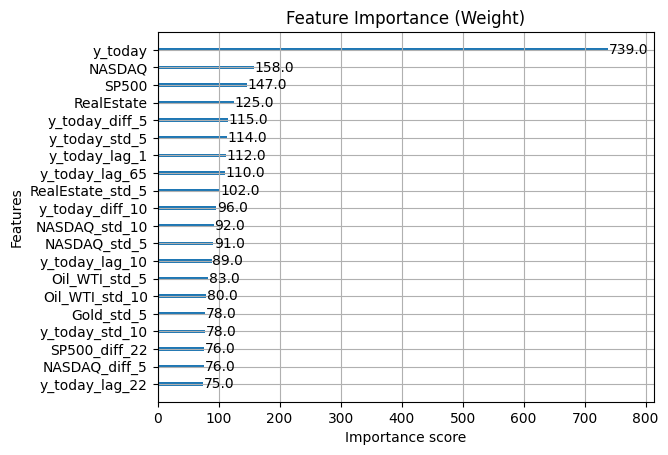

['y_today', 'NASDAQ', 'SP500', 'RealEstate', 'y_today_diff_5', 'y_today_std_5', 'y_today_lag_1', 'y_today_lag_65', 'RealEstate_std_5', 'y_today_diff_10', 'NASDAQ_std_10', 'NASDAQ_std_5', 'y_today_lag_10', 'Oil_WTI_std_5', 'Oil_WTI_std_10']


In [13]:
import matplotlib.pyplot as plt
import xgboost # Import the xgboost module

# Plot feature importance based on "weight" (number of times a feature appears in a tree)
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Weight)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='weight')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_weight_features_list = df_importance['Feature'].head(15).tolist()
print(top_weight_features_list)

<Figure size 1000x600 with 0 Axes>

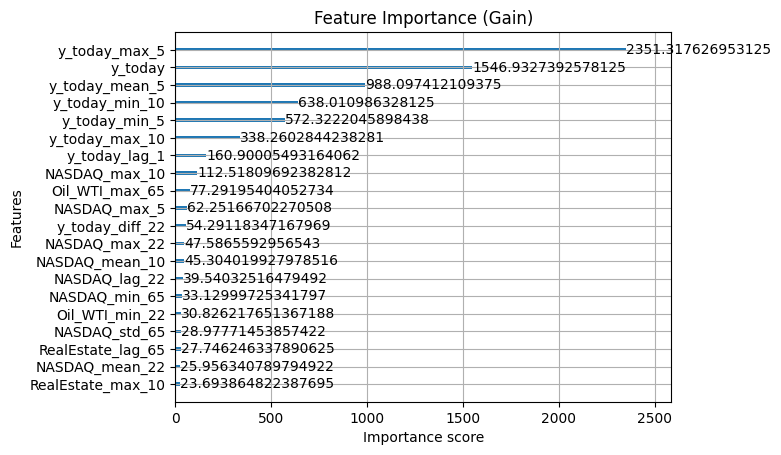

['y_today_max_5', 'y_today', 'y_today_mean_5', 'y_today_min_10', 'y_today_min_5', 'y_today_max_10', 'y_today_lag_1', 'NASDAQ_max_10', 'Oil_WTI_max_65', 'NASDAQ_max_5', 'y_today_diff_22', 'NASDAQ_max_22', 'NASDAQ_mean_10', 'NASDAQ_lag_22', 'NASDAQ_min_65']


In [14]:
# OPTIONAL: Plot based on "gain" (average gain of splits which use the feature)
# "Gain" is often more accurate for finding what actually drives the prediction.
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, importance_type='gain', max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Gain)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='gain')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_gain_features_list = df_importance['Feature'].head(15).tolist()
print(top_gain_features_list)

In [15]:
top_features = list(set(top_gain_features_list) | set(top_weight_features_list))
top_features

['RealEstate_std_5',
 'NASDAQ',
 'y_today_min_5',
 'SP500',
 'NASDAQ_max_5',
 'y_today_mean_5',
 'y_today_lag_1',
 'NASDAQ_max_22',
 'y_today_diff_5',
 'y_today_std_5',
 'Oil_WTI_max_65',
 'NASDAQ_mean_10',
 'NASDAQ_std_10',
 'y_today_min_10',
 'Oil_WTI_std_10',
 'y_today_lag_10',
 'RealEstate',
 'y_today',
 'Oil_WTI_std_5',
 'y_today_max_5',
 'y_today_lag_65',
 'NASDAQ_max_10',
 'y_today_diff_22',
 'y_today_diff_10',
 'y_today_max_10',
 'NASDAQ_min_65',
 'NASDAQ_lag_22',
 'NASDAQ_std_5']

# Final df

In [16]:
final_df = df[['Date','y_tomorrow','y_today'] + top_features]
final_df

,Date,y_tomorrow,y_today,RealEstate_std_5,NASDAQ,y_today_min_5,SP500,NASDAQ_max_5,y_today_mean_5,y_today_lag_1,...,Oil_WTI_std_5,y_today_max_5,y_today_lag_65,NASDAQ_max_10,y_today_diff_22,y_today_diff_10,y_today_max_10,NASDAQ_min_65,NASDAQ_lag_22,NASDAQ_std_5
65,2021-11-01,83.910004,84.050003,0.506404,1795.099976,82.660004,24.920000,1801.599976,83.548001,83.570000,...,25.123596,84.650002,73.949997,1806.000000,9.020004,1.610001,84.650002,1721.500000,1755.300049,7.015196
66,2021-11-02,80.860001,83.910004,0.560261,1788.699951,82.660004,25.570000,1801.599976,83.400002,84.050003,...,29.588345,84.050003,71.260002,1806.000000,8.030006,0.950005,84.650002,1721.500000,1757.000000,7.425163
67,2021-11-03,78.809998,80.860001,0.496498,1763.599976,80.860001,25.379999,1801.599976,83.040001,83.910004,...,25.299304,84.050003,70.559998,1806.000000,3.239998,-3.010002,84.650002,1721.500000,1766.199951,14.520845
68,2021-11-04,81.269997,78.809998,0.483043,1793.000000,78.809998,26.370001,1795.099976,82.240001,80.860001,...,31.577177,84.050003,68.150002,1806.000000,-0.120003,-3.690002,84.650002,1721.500000,1759.599976,12.660451
69,2021-11-05,81.930000,81.269997,0.358291,1816.400024,78.809998,27.150000,1816.400024,81.780000,78.809998,...,34.488136,84.050003,69.089996,1816.400024,3.839996,-2.490005,84.650002,1721.500000,1760.500000,18.850561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2025-11-28,59.320000,58.549999,0.767431,4218.299805,57.950001,1.400000,4218.299805,58.410001,58.650002,...,96.922756,58.840000,64.150002,4218.299805,-1.600002,-0.139999,60.740002,3431.800049,3966.199951,57.166263
1091,2025-12-01,58.639999,59.320000,0.604177,4239.299805,57.950001,1.280000,4239.299805,58.662000,58.549999,...,55.445782,59.320000,64.599998,4239.299805,-1.160000,-0.770000,60.740002,3473.699951,3983.699951,59.589394
1092,2025-12-02,58.950001,58.639999,0.552294,4186.600098,57.950001,1.220000,4239.299805,58.622000,59.320000,...,30.768725,59.320000,64.010002,4239.299805,-1.930000,-1.270000,60.740002,3549.399902,4001.300049,40.119096
1093,2025-12-03,59.669998,58.950001,0.589295,4199.299805,58.549999,1.330000,4239.299805,58.822000,58.639999,...,18.408588,59.320000,65.589996,4239.299805,-2.029999,-1.790001,59.439999,3565.800049,3982.199951,28.527594


# Pickle, CSV

In [17]:
df_pickle_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.df.pkl"
df_csv_path = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"

final_df.to_pickle(df_pickle_path)
final_df.to_csv(df_csv_path)